# MiniEP1 - Aproximação de Integrais usando Médias e Amostragem Uniforme

## Entrega do miniEP1

Preencha o nome dos 5 membros do seu grupo na tabela abaixo:

| Nome | NUSP |
|------|------|
| Caio Andrade | 9797232 |
| Caio Fontes | 10692061 |
| Eduardo Laurentino | 8988212 |
| Thiago Teixeira | 10736987 |
| Washington Meireles | 10737157 |

**Apenas um dos membros** deverá entregar **este arquivo** `.ipynb`, com as soluções do miniEP1 **feitas pelo grupo**.

## Configuração do Ambiente

A primeira tarefa do miniEP1 é instalar e configurar o ambiente.

### Julia, Jupyter, IJulia

Para fazer o miniEP1, você vai precisar:

- [Instalar o Jupyter Notebook](https://jupyter.readthedocs.io/en/latest/install.html)
- Instalar Julia 1.3:
    - [Baixando o binário](https://julialang.org/downloads/)
    - **ou** [usando seu gerenciador de pacotes](https://julialang.org/downloads/platform/)
- Instalar o pacote *IJulia*:
    - Inicie o interpretador Julia
    - Digite `] add IJulia` e pressione `<ENTER>`
    
Depois disso, você vai conseguir iniciar o arquivo `.ipynb` do miniEP1.

### Pacotes Julia para o miniEP1

Os pacotes necessários para o miniEP1 estão listados no arquivo `Project.toml`, mas você pode instalar e atualizar os pacotes rodando a célula abaixo:

In [1]:
] up

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  100.0 %.0 % Resolving package versions...
  Updating `~/USP/Paralela/EP1/Project.toml`
 [no changes]
  Updating `~/USP/Paralela/EP1/Manifest.toml`
 [no changes]


Verifique o status dos pacotes, e se há algum problema, com o comando:

In [2]:
] st

    Status `~/USP/Paralela/EP1/Project.toml`
  [a93c6f00] DataFrames v0.20.2
  [31c24e10] Distributions v0.23.2
  [7073ff75] IJulia v1.21.1
  [1a8c2f83] Query v0.12.2
  [f3b207a7] StatsPlots v0.14.3


## Integração por Método de Monte Carlo

O objetivo deste miniEP é relembrar e aplicar alguns conceitos de estatística, independentes de linguagens de programação. Escolhemos usar a linguagem Julia para os experimentos, análises e geração de gráficos, mas a metodologia desenvolvida pode ser usada com qualquer ferramenta.

Você deve ler o texto neste arquivo e ir executando as células de código que encontrar. Assim vai definindo as funções progressivamente e vai gerar gráficos no final. Julia é uma linguagem compilada *Just-in-Time*, e a primeira vez que você executa uma célula pode levar algum tempo. Isso é por que os pacotes estão sendo compilados. A segunda execução da mesma função será mais rápida, verifique!

Vamos estimar o valor de algumas integrais usando o método de integração de Monte Carlo. A intuição por trás do método é que a integral de uma função $f$ pode ser estimada pela média do valor de $f$ num conjunto suficientemente grande de pontos obtidos a partir de uma distribuição uniforme.

Mais formalmente, para um conjunto de pontos $x_1,\dots,x_N$ uniformemente amostrados num intervalo $[a,b]$, a integral de $f$ no intervalo $[a,b]$ pode ser aproximada por:

$$
\int_{a}^{b} f(x)dx \approx \mathbb{E}\left[\left(b - a\right)\dfrac{1}{N}\sum\limits_{i = 1}^{N}{f(x_i)}\right] 
$$

Para uma representação gráfica da intuição, e para a prova dessa aproximação, veja [esta página](https://www.scratchapixel.com/lessons/mathematics-physics-for-computer-graphics/monte-carlo-methods-in-practice/monte-carlo-integration).

O código abaixo define a função `monte_carlo_integrate`, que estima a integral de uma função `f` num intervalo `interval`, usando o método de Monte Carlo com amostras dadas pelo valor de `samples`. O código usa aplicação vetorizada de funções, através da sintaxe `função.(vetor)`, mas os comentários contêm código equivalente de uma versão usando loops. Usamos o pacote `Distributions` para gerar números pseudoaleatórios no intervalo $[a,b]$. Execute a célula abaixo:

In [18]:
using StatsPlots, Distributions, DataFrames, Query

function monte_carlo_integrate(f, interval, samples = 100)
    xs = rand(Uniform(interval[1], interval[2]), samples)
    
    # Using for loops:
    # accumulator = 0
    #
    # for x in xs
    #     accumulator += f(x)
    # end
    #
    # return accumulator / samples
    
    # Using vectorized function application:
    return sum(f.(xs)*(interval[2] - interval[1])) / samples
end

monte_carlo_integrate (generic function with 2 methods)

### Primeiro Exemplo

Usamos a função `make_f1` abaixo para encapsular o parâmetro $a$ de uma função definida por:

$$
f_1(x) = \dfrac{2}{\sqrt{a ^ 2 - x ^ 2}}
$$

Se quiser saber mais, leia sobre [funções anônimas em Julia](https://docs.julialang.org/en/v1/manual/functions/#man-anonymous-functions-1).

Usando $a = 1$, definimos a função `f1`. A integral da função $f_1$, definida acima, é [dada por](https://en.wikipedia.org/wiki/List_of_definite_integrals#Definite_integrals_involving_rational_or_irrational_expressions):

$$
\int_{0}^{a}{f_1(x)dx} = \int_{0}^{a}{\dfrac{2}{\sqrt{a ^ 2 - x ^ 2}}dx} = \pi
$$

Vamos estimar a integral da função $f_1$ usando o método de Monte Carlo. Execute a célula abaixo:

In [19]:
function make_f1(a)
    return x -> 2 / (sqrt((a ^ 2) - (x ^ 2)))
end


a = 1
f1 = make_f1(a)

#23 (generic function with 1 method)

### Executando Experimentos e Gerando Resultados

A função `run_experiments` recebe uma função alvo `target_f`, um intervalo `interval`, um número de amostras `samples`, e a quantidade de repetições da estimação `repetitions` que devem ser feitas. A função devolve uma [estrutura do tipo `DataFrame`](https://juliadata.github.io/DataFrames.jl/stable/), que é essencialmente uma matriz com colunas nomeadas e de tipo fixo.

Abstrações como os `DataFrames` são extremamente úteis para representar dados tabelados, e são muito usadas em computação científica e em experimentos computacionais em geral. As linguagens [Python](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) e [R](https://www.rdocumentation.org/packages/base/versions/3.6.2/topics/data.frame) também têm abstrações equivalentes.

Nossa função "cresce" um `DataFrame` linha a linha, à medida que executa os experimentos. É prática comum repetir parâmetros para os experimentos, como a coluna `func` do nosso `DataFrame`, pois assim podemos misturar experimentos diferentes numa mesma estrutura.

In [25]:
function run_experiments(target_f, interval, samples, repetitions)
    results = DataFrame(func = String[], samples = Int[], integral = Float64[])
    
    for s in samples
        for r in 1:repetitions
            append!(results, DataFrame(func = ["target_f"],
                    samples = [s],
                    integral = monte_carlo_integrate(target_f, interval, s)))    
        end
    end
    
    return results
end

results = run_experiments(f1, [0, a], [10 ^ x for x in 0:5], 20)

,func,samples,integral
,String,Int64,Float64
1,target_f,1,4.03295
2,target_f,1,2.10752
3,target_f,1,3.67974
4,target_f,1,2.05907
5,target_f,1,2.13951
6,target_f,1,2.23555
7,target_f,1,6.99007
8,target_f,1,2.09549
9,target_f,1,2.06803


### Estimando a Integral e Manipulando os Resultados

Ao repetir a estimativa de uma integral para um número fixo de amostras, esperamos observar propriedades interessantes da variação do valor estimado. Neste miniEP, vamos nos preocupar com a *média* e o *desvio padrão* das amostras, e vamos calcular um *intervalo de confiança* de 95%.

A função `parse_results` recebe um `DataFrame` gerado pela função `run_experiments`, e gera um novo `DataFrame` com os valores da média e intervalo de confiança 95% das estimativas repetidas.

Utilizamos o operador *pipe* `|>` e pacote [Query](https://www.queryverse.org/Query.jl/stable/) para fazer os cálculos. O operador `|>` é binário, e seu significado é "*passe o argumento da esquerda como primeiro parâmetro da função à direita*":

In [21]:
? |>

search: |>



```
|>(x, f)
```

Applies a function to the preceding argument. This allows for easy function chaining.

# Examples

```jldoctest
julia> [1:5;] |> x->x.^2 |> sum |> inv
0.01818181818181818
```


A [macro](https://docs.julialang.org/en/v1/manual/metaprogramming/#man-macros-1) `@groupby` agrupa as linhas de um `DataFrame` pela variável passada como parâmetro. O caractere `_` faz referência ao `DataFrame` passado pelo operador `|>`.

A macro `@map` recebe um dicionário de funções, onde a chave será uma coluna do novo `DataFrame`, e o valor é uma função envolvendo ou não as colunas originais.

A função de chave `mean_integral`, por exemplo, calcula a média dos valores da coluna `integral` original, agrupada por `samples`. A coluna `ci_estimate`, por sua vez, conterá uma estimativa do intervalo de confiança 95%.

O operador `|>` e o pacote Query permitem escrever código muito similar ao produzido pela [biblioteca dplyr](https://dplyr.tidyverse.org/) da linguagem R. Execute a célula abaixo:

In [22]:
function parse_results(results, target_integral)
    parsed_results = results |>
                    @groupby(_.samples) |>
                    @map({samples = key(_),
                          mean_integral = mean(_.integral),
                          ci_estimate = 1.96 * std(_.integral),
                          target = target_integral}) |>
                    DataFrame
    
    return parsed_results
end

parsed_results = parse_results(results, pi)

,samples,mean_integral,ci_estimate,target
,Int64,Float64,Float64,Irration…
1,1,2.80046,2.32116,π
2,10,3.01492,1.32197,π
3,100,2.99538,0.430451,π
4,1000,3.09803,0.214687,π
5,10000,3.14137,0.127584,π
6,100000,3.13708,0.0276273,π


### Análise Visual: Gerando Gráficos

A função `plot_raw_results` gera um gráfico com cada uma das repetições da estimativa do valor da integral, no eixo y, para cada uma das quantidades de repetições, no eixo x. Usamos o [pacote Plots](https://docs.juliaplots.org/latest/) para gerar os gráficos.

Para o miniEP1, você não precisa escrever seus próprios gráficos, mas recomendamos fortemente que você aprenda alguma biblioteca de plotagem, pois vai precisar delas nos EPs seguintes.

Sugerimos aprender uma das seguintes bibliotecas:

- [ggplot2](https://ggplot2.tidyverse.org/) (R)
- [matplotlib](https://matplotlib.org/) (Python)
- [Plots](https://docs.juliaplots.org/latest/) (Julia)

Todas essas bibliotecas podem ser usadas em Notebooks Jupyter. Execute a célula abaixo:

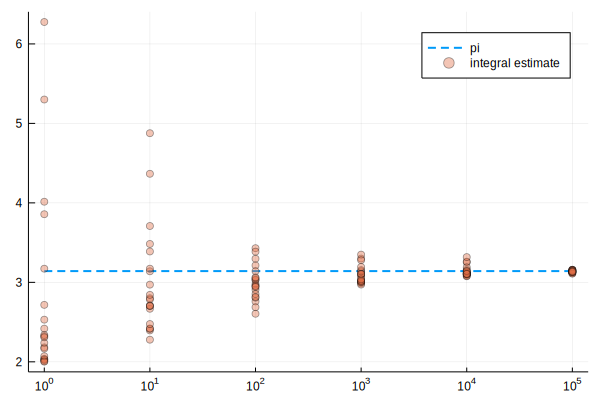

In [23]:
function plot_raw_results(parsed_results, target_label)
    plot(parsed_results.samples,
         parsed_results.target,
         labels = target_label,
         line = :dash,
         width = 2.0)
    scatter!(results.samples,
             results.integral,             
             xscale = :log10,
             alpha = 0.4,
             labels = "integral estimate")
end

plot_raw_results(parsed_results, "pi")

### Exercícios

Os exercícios procuram revisitar conceitos de estatística básica, dando a oportunidade de analisar qualitativa e quantitativamente resultados de experimentos computacionais. A metodologia exercitada aqui será útil nos EPs subsequentes, e em casos futuros onde a análise de experimentos seja necessária.

#### Exercício 1

**a)** Execute a célula acima para gerar o gráfico. Observando o gráfico gerado, descreva *qualitativamente* o comportamento das estimativas da integral, em relação ao seu valor esperado, à medida que aumentamos o número de pontos amostrados. Use a célula abaixo para escrever sua resposta.

**R:** O gráfico acima evidencia que para uma determinada função integrável num determinado intervalo, quanto maior o tamanho da amostra, isto é, quanto maior a quantidade de pontos no intervalo em questão para os quais se calcula o valor da função a ser integrada, mais a média desses valores se aproxima do verdadeiro valor da integral desta função definida no respectivo intervalo.

Sucintamente, quanto maior o número de pontos amostrados mais a estimativa da integral se aproxima do valor esperado. 

**b)** Leia o verbete sobre [valor esperado](https://en.wikipedia.org/wiki/Expected_value) na Wikipedia, e escreva um parágrafo definindo a média de uma amostra. Como podemos interpretar a média? Escreva uma fórmula em $\LaTeX$ para a média.

**R:** Define-se a média de uma amostra X com N elementos, $X = {x_i} (i \in {1, ... N})$, como a soma dos valores individuais dos elementos que compõem a amostra, $x_i$, didivida pelo número de valores amostrados (o tamanho da amostra, N).

Para um N suficientemente grande, podemos interpretar a média de uma amostra como uma boa aproximação do verdadeiro valor a que se refere a amostra em questão. Em outras palavras, para $N\rightarrow \infty$ temos que a média amostral é um estimador enviesado e consistente do verdadeiro na população, isto é, podemos interpretar a média como o valor esperado da função de distribuição que rege nossa amostra. Isso se dá pelo fato de que intervalos de valores que se repetem mais são somados mais vezes, o que numa concepção frequentista de probabilidade acaba por produzir o mesmo efeito de ponderar cada valor por sua probabilidade de ocorrência. 

Fórmula:

$$
X_{média} = \frac{1}{N}\sum^{N}_{i=1}x_i
$$

**c)** Leia o verbete sobre [intervalo de confiança](https://en.wikipedia.org/wiki/Confidence_interval) na Wikipedia, e escreva um parágrafo com uma **descrição da intuição** por trás da definição de intervalo de confiança. Explique também a relação entre a variância estimada de uma amostra, o desvio padrão, e o intervalo de confiança a 95%.

Escreva fórmulas em $\LaTeX$ para a variância e o desvio padrão, mas não se preocupe com a formalização da definição do intervalo de confiança, estamos interessados na intuição por trás da ideia.

**R:** Na investigação (por inferencia) estatística de um determinado valor, um intervalo de confiança consiste de um intervalo fechado de valores - gerado a partir de uma determinada regra - para o qual há uma alta probabilidade (por exemplo, 95%) de que o valor real da variável sendo investigada esteja contido nesse intervalo.

Seja $X$ a medida populacional cujo valor queremos inferir e seja $x$ o valor estimado dessa medida obtido à partir de uma amostra da população em questão, chamado _ponto de estimação_. 

Temos que um Intervalo de Confiança (IC) a 95% consiste de um intervalo fechado centrado no _ponto de estimação_ e com uma semi-amplitude de aproximadamente Z vezes* o valor do desvio padrão da população dividido pela raíz do tamanho da amostra. Isto é, sendo $\sigma^2$ a variância da população, temos que $\sqrt{\sigma^2} = \sigma$ é o respectivo desvio padrão, e o intervalo de confiança IC é tal que

$$
IC = \{ x +- Z *\frac{\sigma}{\sqrt{N}}\}
$$

Onde $Z$ é o que chamamos de $Z-score$ é um valor definido pela distribuição $N(0,1)$ e, de forma simplificada, o $Z-score$ de uma observação é o número de desvios padrões de distância da média. Sabemos pela tabela de caracterização da distribuição normal padrão que deve-se usar $z = 1.96$ para intervalos de confiança a 95%.

Quando o valor da variância (e consequentemente do desvio padrão) na população não é conhecido, devemos estimar à partir da amostra. Seja $s$ a variância amostral e $S$ a respectiva estimativa do desvio padrão na população. Temos que tais valores são obtidos da seguinte maneira:


Variância amostral ($s$):

$$
s = \frac{\displaystyle\sum_{i=1}^{n}(x_i - X_{média})^2} {n - 1}
$$

Estimativa do desvio padrão ($S$):

$$
S = \sqrt{\frac{\displaystyle\sum_{i=1}^{n}(x_i - X_{média})^2} {n - 1}} = \sqrt{s}
$$

Nesse caso, temos portanto que o intervalo de confiança é tal que

$$
IC = \{ x +- Z *\frac{S}{\sqrt{N}}\}
$$

**d)** A função `plot_results` gera um gráfico sumarizando os dados da figura anterior. O gráfico gerado mostra a média das estimativas e o intervalo de confiança 95%, calculados anteriormente.

Execute a célula abaixo e gere o gráfico. Interprete os resultados *quantitativamente*, em termos da média e do intervalo de confiança. Responda também:

1. Esse é o comportamento que você esperava para a estimativa pelo método de Monte Carlo? Por que?
2. Que engano poderíamos cometer, se não calculássemos o intervalo de confiança?

**R:** 

_Quantitativamente_ , basicamente quanto maior o tamanho da amostra temos que: i) mais o valor da média dos resultados obtidos em cada elemento da amostra se aproxima do verdadeiro valor da função; e ii) menor a amplitude do intervalo de confiança associado a respectiva média. 

1. Este comportamento é sim o esperado do método de Monte Carlo pois este método é, em essência, uma média amostral - cuja população é o valor verdadeiro de uma função real. Dessa forma, como vimos anteriormente a  respeito a interpretação da média de uma amostra, a estimação de Monte Carlo converge para o valor esperado da função a medida que o tamanho da amostra se aproxima do infinito - o que nesse caso significa que quanto maior a quantidade de elementos na amostra, maior é a probabilidade de o método convergir para a resposta correta. 
2. Como a taxa de convergência deste método é proporcional à variância da respectiva função e, sendo o erro padrão que define a amplitude do intervalo de confiança igual a $\sigma^2/n = \sigma/\sqrt{n}$, temos que é preciso amostras consideravelmente maiores para reduzir o erro associado a estimativa obtida pelo método. Calcular o intervalo de confiança, portanto, nos permite melhor avaliar o resultado obtido do ponto de vista da acurácia da estimativa.


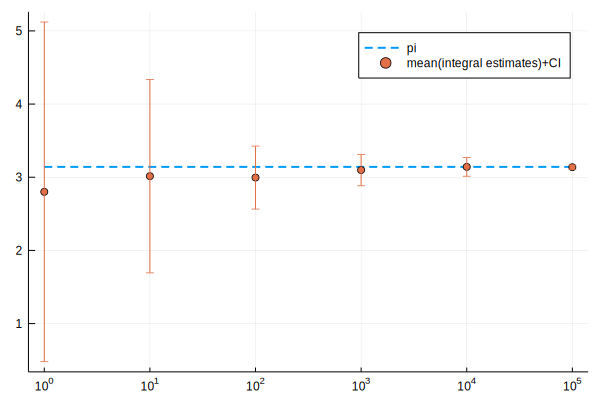

In [24]:
function plot_results(parsed_results, target_label)
    plot(parsed_results.samples,
         parsed_results.target,
         labels = target_label,
         line = :dash,
         width = 2.0)
    scatter!(parsed_results.samples,
             parsed_results.mean_integral,             
             yerror = parsed_results.ci_estimate,        
             xscale = :log10,        
             labels = "mean(integral estimates)+CI")
end

plot_results(parsed_results, "pi")

#### Exercício 2

**a)** Implemente em Julia a [função descrita abaixo](https://towardsdatascience.com/monte-carlo-integration-is-magic-c7f817d89610):

$$
f_2(x) = 2xe^{x^2}
$$

A integral de $f_2$ é dada por:

$$
\int_{0}^{1}{f_2(x)dx} = \int_{0}^{1}{2xe^{x^2}}dx = e - 1
$$

Vamos estimar essa integral usando método de Monte Carlo. Use a célula abaixo, e apenas complete a definição de `f2`. Execute a célula.

In [15]:
function f2(x)
    return 2*x*exp(x^2)
end


results = run_experiments(f2, [0.0, 1.0], [10 ^ x for x in 0:5], 30)
parsed_results = parse_results(results, Base.MathConstants.e - 1)

,samples,mean_integral,ci_estimate,target
,Int64,Float64,Float64,Float64
1,1,1.74683,3.07425,1.71828
2,10,1.63509,1.13159,1.71828
3,100,1.72379,0.233516,1.71828
4,1000,1.72038,0.0898104,1.71828
5,10000,1.71916,0.0266198,1.71828
6,100000,1.7183,0.00863283,1.71828


**b)** Gere as duas figuras, executando as células abaixo. Interprete os resultados *quantitativamente*, como fez no exercício **1d**. Escreva sua resposta na célula abaixo.

R: Cada um dos pontos no primeiro gráfico corresponde ao resultado de uma série de 30 repetições da aplicação do Método de Monte Carlo numa amostra de tamanho $10^n, n \in {0, 1, 2, 3, 4, 5}$ (conforme indicado no eixo coordenado). Nota-se neste gráfico que quanto maior o tamanho da amostra, menor a variância dos resultados obtidos, de tal forma que, em conformidade com o que se espera do método, quanto maior o tamanho da amostra mais as estimativas se aproximam do verdadeiro valor. Por exemplo, amostras de tamanho menor levaram muito mais estimativas distantes do verdadeiro valor do que suficientemente próximas, enquanto amostras maiores levaram a situação oposta, com quase todas as estimativas significamentemente próximas do valor real. 

Desta forma, como a amplitude do intervalo de confiança é essencialmente determinada pelo desvio padrão dos valores obtidos (conforme vimos anteriormente, vide questão 1-c), no segundo gráfico temos que muito embora a média das estimativas estejam em todos os casos dos diferentes tamanhos de amostras próximos do valor real, há diferenças gritantes nos respectivos intervalos de confiança. Enquanto nas amostras maiores a menor variância das estimativas se reflete em intervalos de confiança menores e que oferecem maior precisão para a análise, as amostras menores possuem intervalos de confiança com amplitude bastante grandes e inacurados, como exemplo máximo disso o caso das estimativas em amostra de tamanho unitário, onde obtivemos um intervalo de confiança que se extende a vlaores negativos, mesmo que nenhum resultado experimental os atinja (visto que são somas de números positivos).

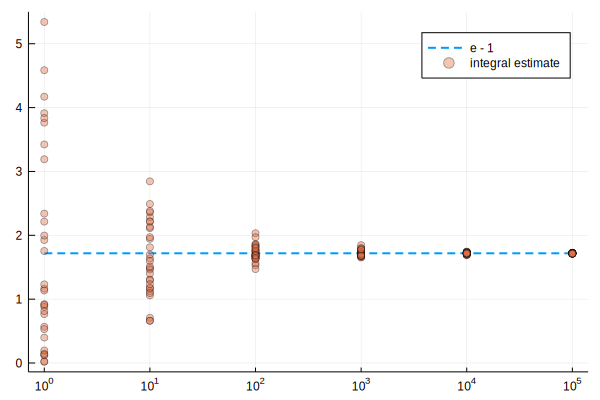

In [16]:
plot_raw_results(parsed_results, "e - 1")

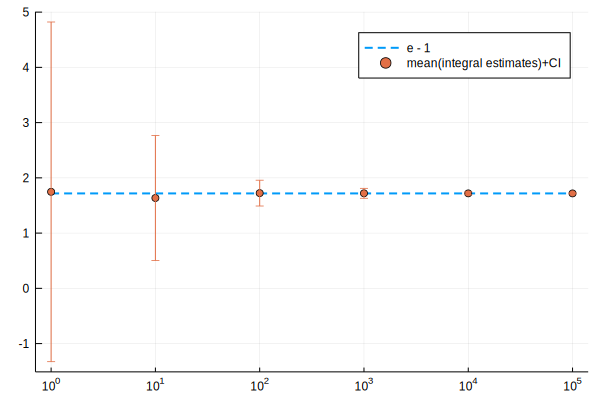

In [17]:
plot_results(parsed_results,"e - 1")

**c)** Implemente em Julia a [função abaixo](https://en.wikipedia.org/wiki/Euler%E2%80%93Mascheroni_constant#Integrals):

$$
f_3(x) = \dfrac{1}{\text{ln}x} + \dfrac{1}{1 - x}
$$

A integral de $f_3$ é dada por:

$$
\int_{0}^{1}{f_3(x)dx} = \int_{0}^{1}{\left(\dfrac{1}{\text{ln}x} + \dfrac{1}{1 - x}\right)dx} = \gamma
$$

Use a célula abaixo, e apenas complete a definição de `f3`. Execute a célula.

In [34]:
function f3(x)
    return 1/log(x) + 1/(1-x)
end

results = run_experiments(f3, [0.0, 1.0], [10 ^ x for x in 0:5], 20)
parsed_results = parse_results(results, Base.MathConstants.eulergamma)

,samples,mean_integral,ci_estimate,target
,Int64,Float64,Float64,Irration…
1,1,0.601575,0.100126,γ
2,10,0.57212,0.0387469,γ
3,100,0.577808,0.0136289,γ
4,1000,0.577883,0.00515343,γ
5,10000,0.577322,0.00109933,γ
6,100000,0.577142,0.000450815,γ


**d)** Gere as duas figuras, executando as células abaixo. Interprete os resultados *quantitativamente*, como fez no exercício **1d**. Escreva sua resposta na célula abaixo.

**R:** De forma geral, temos nesses dois gráficos o mesmo comportamento descrito na resposta 2-b. Ainda que dessa vez os resultados do primeiro gráfico consistam de uma série de 20 repetições (e não 30, como anteriormente) da aplicação do Método de Monte Carlo, ainda temos o já descrito comportamento de amostras de tamanhos maiores levando a estimativas mais próximas do verdadeiro valor, com menor variância nos resultados que, no segundo gráfico, se reflete em intervalos de confiança para a média dos valores com menor amplitude. 

Quantitativamente, o que pode-se observar de diferença é que neste caso o segundo gráfico nos mostra que mesmo a média dos valores nem sempre está suficientemente próxima do valor real. Enquanto na função da questão 2-b tínhamos a média das estimativas de todos os diferentes tamanhos de amostra sob a linha que demarca o verdadeiro valor, aqui pode-se notar que isso não se aplica nem no caso das amostras de tamanho unitário, cuja média ficou  visivelmente superestimada do verdadeiro valor, nem no caso de amostras de tamanho $10¹$, cuja média ficou subestimada.

Ainda assim, conforme já dito, de forma geral podemos observar a mesma convergência dos valores experimentais e do intervalo de confiança que foi vista nos outros exemplos, confirmando as hipóteses teóricas sobre esse método.

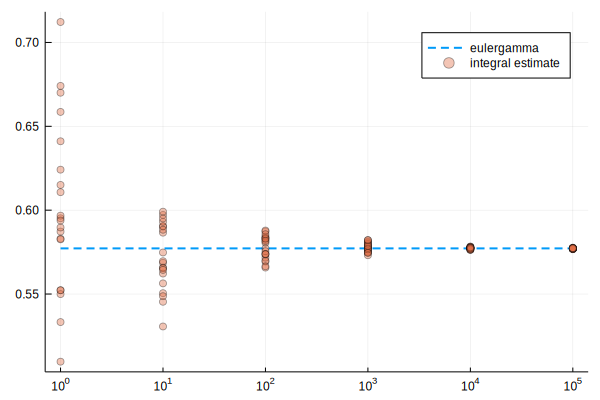

In [35]:
plot_raw_results(parsed_results, "eulergamma")

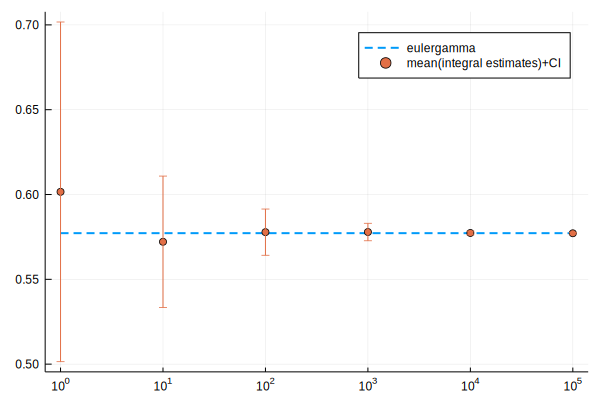

In [36]:
plot_results(parsed_results, "eulergamma")